# How to Use Bluemix Object Storage and Watson Vision

This notebook shows how to use objects in Object Storage with 
Watson Vision.  To use the examples in this notebook, you'll need to have
Object Storage set up and a Watson Vision API Key.  

In [51]:
from swiftclient import Connection
from watson_developer_cloud import VisualRecognitionV3
from IPython.display import Image

## Get your credentials

You must use the bluemix web console to create your 

You can get your credentials using the `cf` command

### Create Vision Service and Key

Create the service instance using the name `python_os_vision`:

`cf cs watson_vision_combined free python_os_vision`

Then create the service key named `notebook`:

`cf create-service-key python_os_vision notebook`

Then you can get the credentials (you only need the `api_key`):

`cf service-key python_os_vision notebook`

### Create Object-Store Service and Key

Create the instance:  

`cf create-service Object-Storage Free pythonosvision`

which will create an instance named `pythonosvision`.  That command is case sensitive.  Once the 
service has finished being created (you can check it's status using `cf service pythonosvision`)
you can create a service key.

`cf create-service-key pythonosvision notebook`

And you can retrieve the info for the service key using:

`cf service-key pythonosvision notebook`

You can put the credentials in the next cell.


In [30]:
creds = {
  "auth_url": None,
  "project": None,
  "projectId": None,
  "region": None,
  "userId": None,
  "username": None,
  "password": None,
  "domainId": None,
  "domainName": None,
  "role": None
}
api_key=None

# Connect to Object Store

This next bit of code connects to the Object Store using the credentials, and 
creates a container if one with the name `container` does not exist.   A `container` 
can be thought of like a folder.  

In [15]:
auth_url = creds['auth_url'] + '/v3' 
password = creds['password']
project_id = creds['projectId']
user_id = creds['userId']
region_name = creds['region']

conn = Connection(key=password,
                  authurl=auth_url,
                  auth_version='3',
                  os_options={"project_id": project_id,
                              "user_id": user_id,
                              "region_name": region_name})
container_name = 'container'
if container_name not in [x['name'] for x in conn.get_account()[1]]:
    print("Creating New Container")
    conn.put_container(container_name)

# Upload the zip files

I've copied the zip files used in the [Watson Vision Demo](https://visual-recognition-demo.mybluemix.net)
locally so I can upload them to object store.  This might take a while.

In [18]:
positive_classes = ['beagle', 'dalmatian', 'husky']
negative_class = ['negatives']
all_classes = positive_classes + negative_class

for f in all_classes:
    with open('./zips/{}.zip'.format(f), 'rb') as cfile:
        print(f)
        conn.put_object(container_name, '{}.zip'.format(f), contents=cfile, content_type='application/zip')
        print("Done")

beagle
Done
dalmatian
Done
husky
Done
negatives
Done


# Instance of Visual Recognition

Next we connect to the visual recognition system.  This requires the api_key
we got earlier.  

In [31]:
vision = VisualRecognitionV3(version="2017-01-01", api_key=api_key)

## Create a new custom classifier

Now we download the files from Object Storage and create a custom classifier.  
We don't need to write the files to disk, but we need to pass them to the creation
method as a tuple.  

The tuple contains `( <File Name>,   <BYTES>,  <Mime Type>)` and has an argument of the form `XXXXX_positive_examples` for positive examples and `negative_examples` for the negative examples. 

In [37]:
negatives = conn.get_object(container_name, 'negatives.zip')
files={'negative_examples': ('negatives.zip', negatives[1], negatives[0]['content-type'])}
for f in positive_classes:
    print("Getting {}".format(f))
    positive = conn.get_object(container_name, '{}.zip'.format(f))
    files['{}_positive_examples'.format(f)]= ('{}.zip'.format(f), positive[1], positive[0]['content-type'])               
print("Done")

Getting beagle
2
Getting dalmatian
3
Getting husky
4


In [45]:
classifier_data = vision.create_classifier('my_dogs_classifier',
                         negative_examples=files['negative_examples'],
                         beagle_positive_examples=files['beagle_positive_examples'],
                         dalmatian_positive_examples=files['dalmatian_positive_examples'],
                         husky_positive_examples=files['husky_positive_examples'])
classifier_data

{u'classes': [{u'class': u'husky'},
  {u'class': u'dalmatian'},
  {u'class': u'beagle'}],
 u'classifier_id': u'my_dogs_classifier_1115198725',
 u'created': u'2017-04-04T18:44:20.528Z',
 u'name': u'my_dogs_classifier',
 u'owner': u'58b61352-678c-44d1-9f40-40edf4ea8d19',
 u'status': u'training'}

The classifier we've create will take a little while to train. Once the status of the classifier is 'ready' we can 
send images to it for classification.  

In [49]:
vision.get_classifier(classifier_data['classifier_id'])

{u'classes': [{u'class': u'husky'},
  {u'class': u'dalmatian'},
  {u'class': u'beagle'}],
 u'classifier_id': u'my_dogs_classifier_1115198725',
 u'created': u'2017-04-04T18:44:20.528Z',
 u'name': u'my_dogs_classifier',
 u'owner': u'58b61352-678c-44d1-9f40-40edf4ea8d19',
 u'status': u'ready'}

The first image we send should not show up in any classes
[[Golden][./zips/goldenretriever-thumbnail.jpg]]

(we didn't send any Golden Retriever images to this classifier).  The second should be recognized as a beagle.  

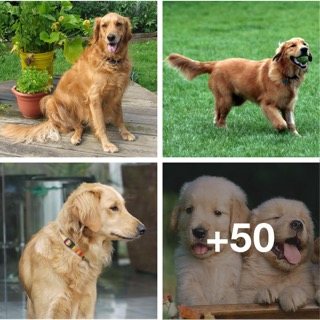

In [54]:
Image(filename='./zips/goldenretriever-thumbnail.jpg')

In [53]:
results = None
with open('./zips/goldenretriever-thumbnail.jpg', 'rb') as gdog:
    results = vision.classify(classifier_ids=[classifier_data['classifier_id']], images_file=gdog)
results

{u'custom_classes': 3,
 u'images': [{u'classifiers': [],
   u'image': u'./zips/goldenretriever-thumbnail.jpg'}],
 u'images_processed': 1}

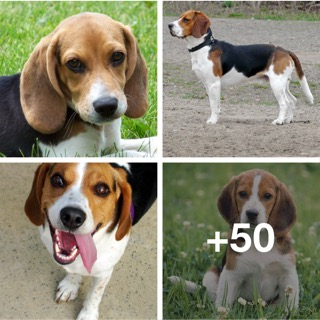

In [55]:
Image(filename='./zips/beagle-thumbnail.jpg')

In [50]:
with open('./zips/beagle-thumbnail.jpg', 'rb') as bdog:
    results = vision.classify(classifier_ids=[classifier_data['classifier_id']], images_file=bdog)
results

{u'custom_classes': 3,
 u'images': [{u'classifiers': [{u'classes': [{u'class': u'beagle',
       u'score': 0.963731}],
     u'classifier_id': u'my_dogs_classifier_1115198725',
     u'name': u'my_dogs_classifier'}],
   u'image': u'./zips/beagle-thumbnail.jpg'}],
 u'images_processed': 1}

# Cleanup

Then we can cleanup our classifiers and objects by removing the ones we've just created.

First, we'll remove the classifier:

In [56]:
vision.delete_classifier(classifier_id=classifier_data['classifier_id'])

{}

Then we'll delete the files in Object Storage.

In [57]:
for f in all_classes:
    print("delete: {}".format(f))
    conn.delete_object(container_name, "{}.zip".format(f))

delete: beagle
delete: dalmatian
delete: husky
delete: negatives


The services and the container are not removed so you can remove them if want or leave them and use the services for other tasks. 